# Benchmarks

## Initialize

In [1]:
%load_ext autoreload
%autoreload 2

import os
from tqdm.auto import tqdm
import pathlib

import numpy as np
import pandas as pd
import lifelines

In [2]:
%env MKL_NUM_THREADS=1
%env NUMEXPR_NUM_THREADS=1
%env OMP_NUM_THREADS=1

env: MKL_NUM_THREADS=1
env: NUMEXPR_NUM_THREADS=1
env: OMP_NUM_THREADS=1


In [3]:
#ray.shutdown()

In [4]:
import ray
ray.init(num_cpus=30, dashboard_port=24763, dashboard_host="0.0.0.0", include_dashboard=True)#, webui_url="0.0.0.0")

2022-01-26 20:43:06,448	INFO services.py:1263 -- View the Ray dashboard at http://10.32.105.2:24763


{'node_ip_address': '10.32.105.2',
 'raylet_ip_address': '10.32.105.2',
 'redis_address': '10.32.105.2:6379',
 'object_store_address': '/tmp/ray/session_2022-01-26_20-43-00_981271_3760350/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-01-26_20-43-00_981271_3760350/sockets/raylet',
 'webui_url': '10.32.105.2:24763',
 'session_dir': '/tmp/ray/session_2022-01-26_20-43-00_981271_3760350',
 'metrics_export_port': 61125,
 'node_id': '16a5062e35a1209bdcbc6e219b67dd8c3bcac1284e314198e5cc8333'}

In [5]:
node = !hostname
if "sc" in node[0]:
    base_path = "/sc-projects/sc-proj-ukb-cvd"
else: base_path = "/data/analysis/ag-reils/ag-reils-shared/cardioRS"
print(base_path)

project_name = "210714_metabolomics"
#data_path = "/data/analysis/ag-reils/steinfej"
data_pre = f"{base_path}/data/2_datasets_pre/{project_name}"
data_post = f"{base_path}/data/3_datasets_post/{project_name}"

project_label = "21_metabolomics_multitask"
project_path = f"{base_path}/results/projects/{project_label}"
figures_path = f"{project_path}/figures"
data_results_path = f"{project_path}/data"
pathlib.Path(figures_path).mkdir(parents=True, exist_ok=True)
pathlib.Path(data_results_path).mkdir(parents=True, exist_ok=True)

/sc-projects/sc-proj-ukb-cvd


In [6]:
# esclude heart failure, venous thrombosis, aortic anyeurism partition21

In [7]:
run = "220126"

In [8]:
data =  pd.read_feather(f"{data_post}/data_merged.feather")

In [9]:
preds_models = pd.read_feather(f"{data_results_path}/predictions_{run}_metabolomics.feather")

In [10]:
endpoints = preds_models.endpoint.unique().tolist()
partitions = preds_models.partition.unique().tolist()

In [11]:
#preds_scores = pd.read_csv(f"{data_results_path}/predictions_scores_210920_long.csv")

In [12]:
data_temp = pd.read_feather(f"{data_post}/data_merged.feather")
eids_dict = {}
for endpoint in tqdm(endpoints):
    eids_incl = data_temp.query(f"NMR_FLAG==True&{endpoint}==False").eid.to_list()
    if endpoint == "M_MACE": eids_incl = data_temp.copy().query(f"NMR_FLAG==True&{endpoint}==False&statins==False").eid.to_list()
    elif endpoint == "M_breast_cancer": eids_incl = data_temp.copy().query(f"NMR_FLAG==True&{endpoint}==False&sex=='Female'").eid.to_list()
    elif endpoint == "M_ovarian_cancer": eids_incl = data_temp.copy().query(f"NMR_FLAG==True&{endpoint}==False&sex=='Female'").eid.to_list()
    elif endpoint == "M_uterus_cancer": eids_incl = data_temp.copy().query(f"NMR_FLAG==True&{endpoint}==False&sex=='Female'").eid.to_list()
    elif endpoint == "M_prostate_cancer": eids_incl = data_temp.copy().query(f"NMR_FLAG==True&{endpoint}==False&sex=='Male'").eid.to_list()
    print(endpoint, len(eids_incl))
    eids_dict[endpoint] = eids_incl

  0%|          | 0/24 [00:00<?, ?it/s]

M_MACE 92629
M_coronary_heart_disease 108551
M_cerebral_stroke 117342
M_peripheral_arterial_disease 115132
M_atrial_fibrillation 116026
M_heart_failure 113636
M_abdominal_aortic_aneurysm 117826
M_venous_thrombosis 114986
M_type_2_diabetes 111745
M_liver_disease 115468
M_renal_disease 111704
M_asthma 102392
M_chronic_obstructuve_pulmonary_disease 110465
M_all_cause_dementia 117245
M_parkinsons_disease 117764
M_lung_cancer 117896
M_non_melanoma_skin_cancer 115996
M_colon_cancer 117617
M_rectal_cancer 117699
M_prostate_cancer 53393
M_breast_cancer 62009
M_cataracts 114345
M_glaucoma 115934
M_fractures 106392


In [13]:
#preds_scores = pd.concat(preds_scores_list, axis=0).reset_index(drop=True)

In [14]:
preds = preds_models.reset_index(drop=True)#-pd.concat([preds_models, preds_scores], axis=0)

In [15]:
endpoints = preds.endpoint.unique().tolist()
endpoint_labels = sorted([f"{e}_event" for e in endpoints]+[f"{e}_event_time" for e in endpoints])
endpoint_data =  pd.read_feather(f"{data_post}/data_merged.feather", columns=["eid"] + endpoint_labels)

In [16]:
preds.partition.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

In [17]:
!ls {data_results_path}

MET_HRs_210819_metabolomics.feather
MET_HRs_210821_metabolomics.feather
NMR_acetone_IMPUTER.pkl
NMR_clinical_ldl_cholesterol_IMPUTER.pkl
REVISION_220110_attrib_raw.feather
REVISION_220111_temp_umap_shap.feather
add_data_211005.feather
adj_partial_effects_metabolomics_210914.feather
adj_partial_effects_metabolomics_210916.feather
adj_partial_effects_metabolomics_210920.feather
adj_partial_effects_metabolomics_210922A.feather
adj_partial_effects_metabolomics_211005_incl_cancer.feather
adj_partial_effects_metabolomics_211006_improved.feather
adj_partial_effects_metabolomics_211007.feather
adj_partial_effects_metabolomics_220126_apoe4.feather
attrib_raw_REVISION.feather
attrib_sample_wide_211028.feather
attributions_210915.feather
attributions_210916.feather
attributions_210917.feather
attributions_210924.feather
attributions_211008.feather
attributions_211014_Kernelexplainer.feather
attributions_211026.feather
benchmark1000_cindex_subgroups_220106.feather
benchmark100_cindex_subgroups_220

In [18]:
# Bootstrapping or even recruitment centers?

In [19]:
# Little bit of QC:

In [20]:
data_test = preds[['eid','endpoint', 'module','features','partition','Ft_10']]#.query("split=='test'")
data_test

modules = data_test.module.unique().tolist()
features = data_test.features.unique().tolist()
partitions = data_test.partition.unique().tolist()

In [21]:
iterations=[i for i in range(1000)]

In [ ]:
from IPython.display import clear_output
#from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc, integrated_brier_score
from lifelines.utils import concordance_index
from dask.diagnostics import ProgressBar

def calculate_per_endpoint(df, endpoint, module, feature, iteration, time):  
    event = [0 if (endpoint_event == 0) | (endpoint_event_time > time) else 1 
             for endpoint_event, endpoint_event_time in zip(df[endpoint+"_event"], df[endpoint+"_event_time"])]
    event_time = [time if (endpoint_event == 0) | (endpoint_event_time > time) else endpoint_event_time 
                  for endpoint_event, endpoint_event_time in zip(df[endpoint+"_event"], df[endpoint+"_event_time"])]
    df = df.assign(event = event, event_time = event_time)
    df = df.dropna(subset=["event_time", f"Ft_{time}", "event"], axis=0)
    
    cindex = 1-concordance_index(df["event_time"], df[f"Ft_{time}"], df["event"])
    #except: cindex=np.nan
    return {"endpoint":endpoint, "module": module, "features": feature, "iteration": iteration, "time":time, "cindex":cindex}

@ray.remote
def calc_per_iteration(data_bm, eids_bs, endpoint, modules, features, iteration):
    rows = []
    for module in tqdm(modules, desc=f"{endpoint} ({iteration})"): 
            temp_module = data_bm.query("module==@module")
            for feature in features:
                temp_features = temp_module.query("features==@feature")
                if len(temp_features)>0:
                    data_object = temp_features[["eid", "Ft_10", f"{endpoint}_event", f"{endpoint}_event_time"]].set_index("eid").loc[eids_bs].reset_index()
                    rows.append(calculate_per_endpoint(data_object, endpoint, module, feature, iteration, time=10))
    return rows

rows = []
for endpoint in tqdm(endpoints):
#for endpoint in tqdm(["M_all_cause_dementia"]):
    data_bm = data_test.set_index("eid").query("endpoint==@endpoint").merge(
        endpoint_data[["eid", f"{endpoint}_event", f"{endpoint}_event_time"]].set_index("eid"), 
        left_index=True, right_index=True, how="left").reset_index()
    data_bm_id = ray.put(data_bm)
    eids = data_bm.eid.unique()
    for iteration in tqdm(iterations): 
        eids_bs = np.random.choice(eids, size=len(eids))
        rows.extend([calc_per_iteration.remote(data_bm_id, eids_bs, endpoint, modules, features, iteration)])

In [ ]:
rows_finished = [y for x in ray.get(rows) for y in x]

M_asthma (880):   0%|          | 0/3 [00:00<?, ?it/s]


In [ ]:
benchmark_endpoints_pp = pd.DataFrame({}).append(rows_finished, ignore_index=True)
clear_output()

In [ ]:
benchmark_endpoints_pp.features.unique()

In [ ]:
name = f"benchmark_cindex_{run}"
benchmark_endpoints_pp.to_feather(f"{data_results_path}/{name}.feather")

In [ ]:
benchmark_endpoints_pp

In [ ]:
raise NotImplementedError('DONE')

In [ ]:
test.query("based_on=='targets'").sample(100)

In [ ]:
1+1

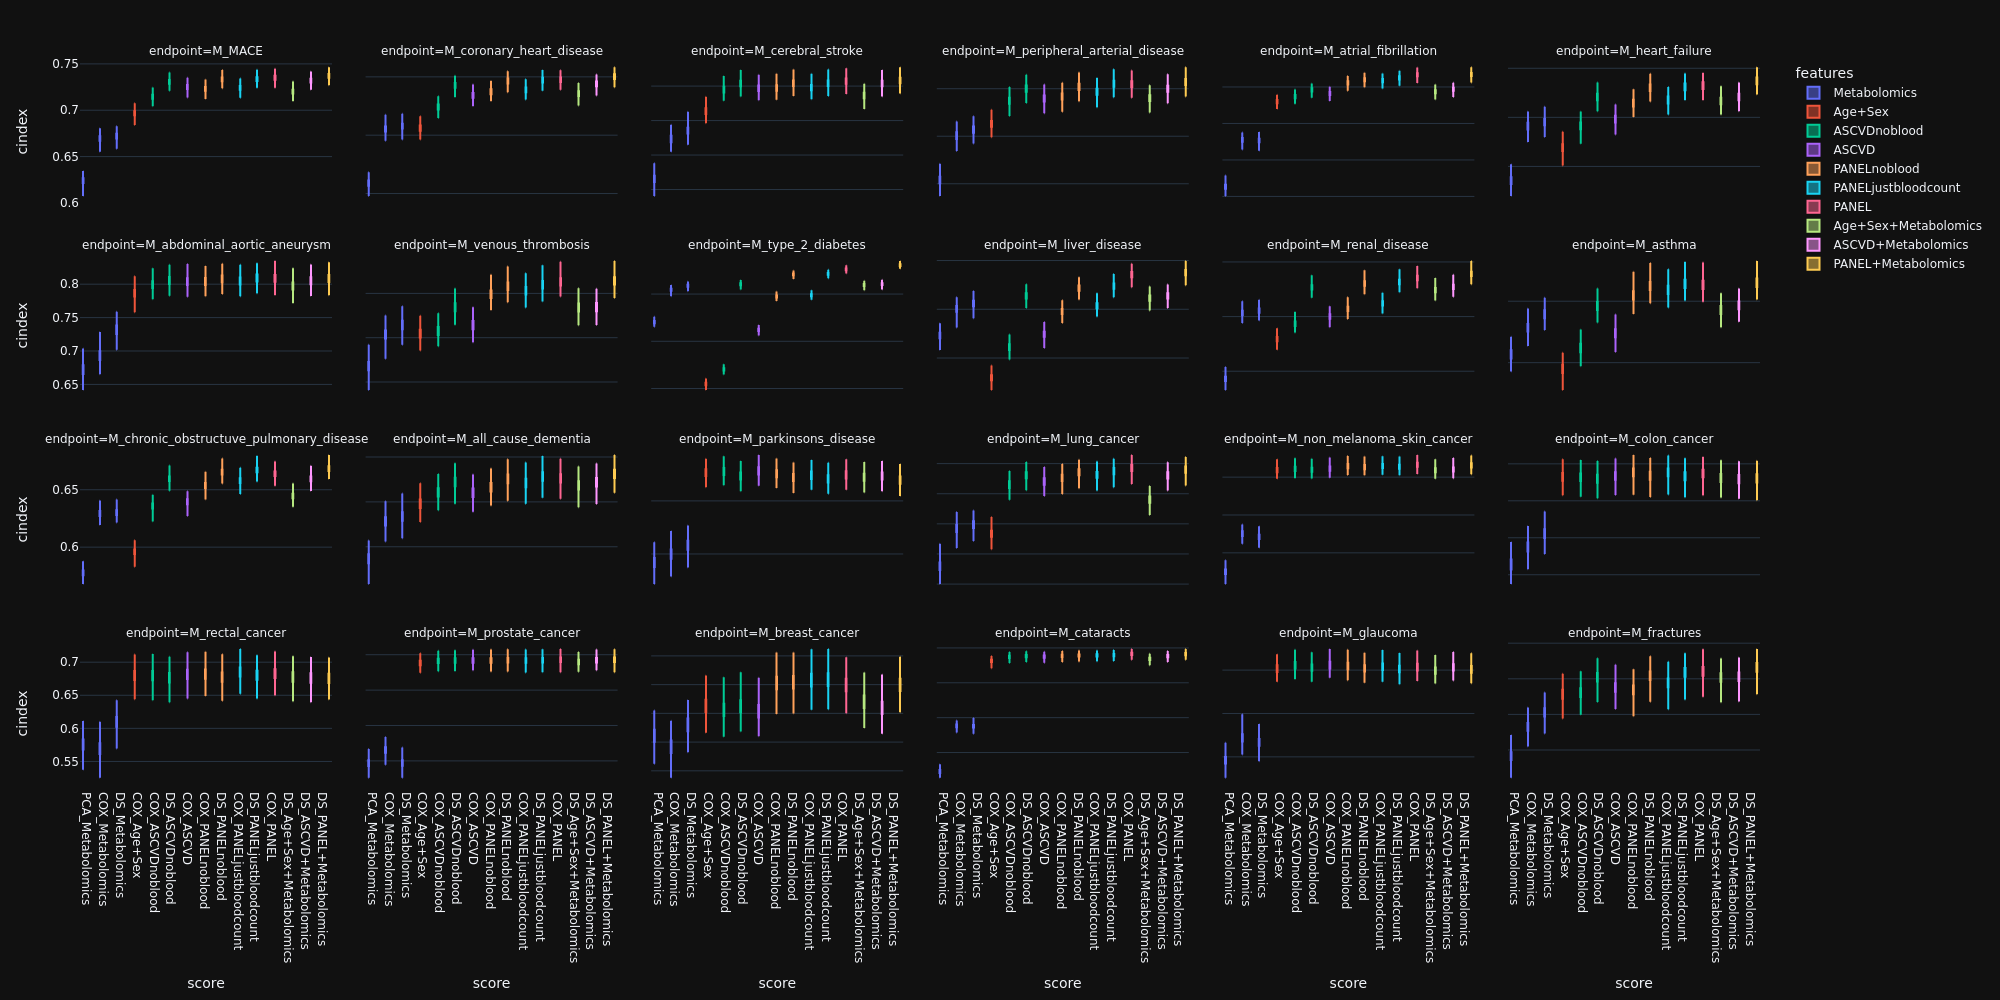

In [23]:
import plotly.express as px
#scores_plot = ["COX_Age+Sex", "COX_Metabolomics", "DS_Metabolomics", "COX_Age+Sex+Metabolomics", "DS_Age+Sex+Metabolomics", "DS_AgeSexMetabolomics"]
temp = benchmark_endpoints_pp.assign(score = lambda x: x.module + "_" + x.features)#.query("score==@scores_plot")
fig = px.box(temp, y="cindex", x="score", points=False, color="features", facet_col="endpoint", facet_col_wrap=6, template="plotly_dark")#,
               #category_orders={"features": ["COX_Age+Sex", "COX_Metabolomics", "DS_Metabolomics", "COX_Age+Sex+Metabolomics", "DS_Age+Sex+Metabolomics", "DS_AgeSexMetabolomics"]})
fig.update_xaxes(matches=None)
fig.update_yaxes(matches=None)
fig.show("png", width=2000, height=1000)

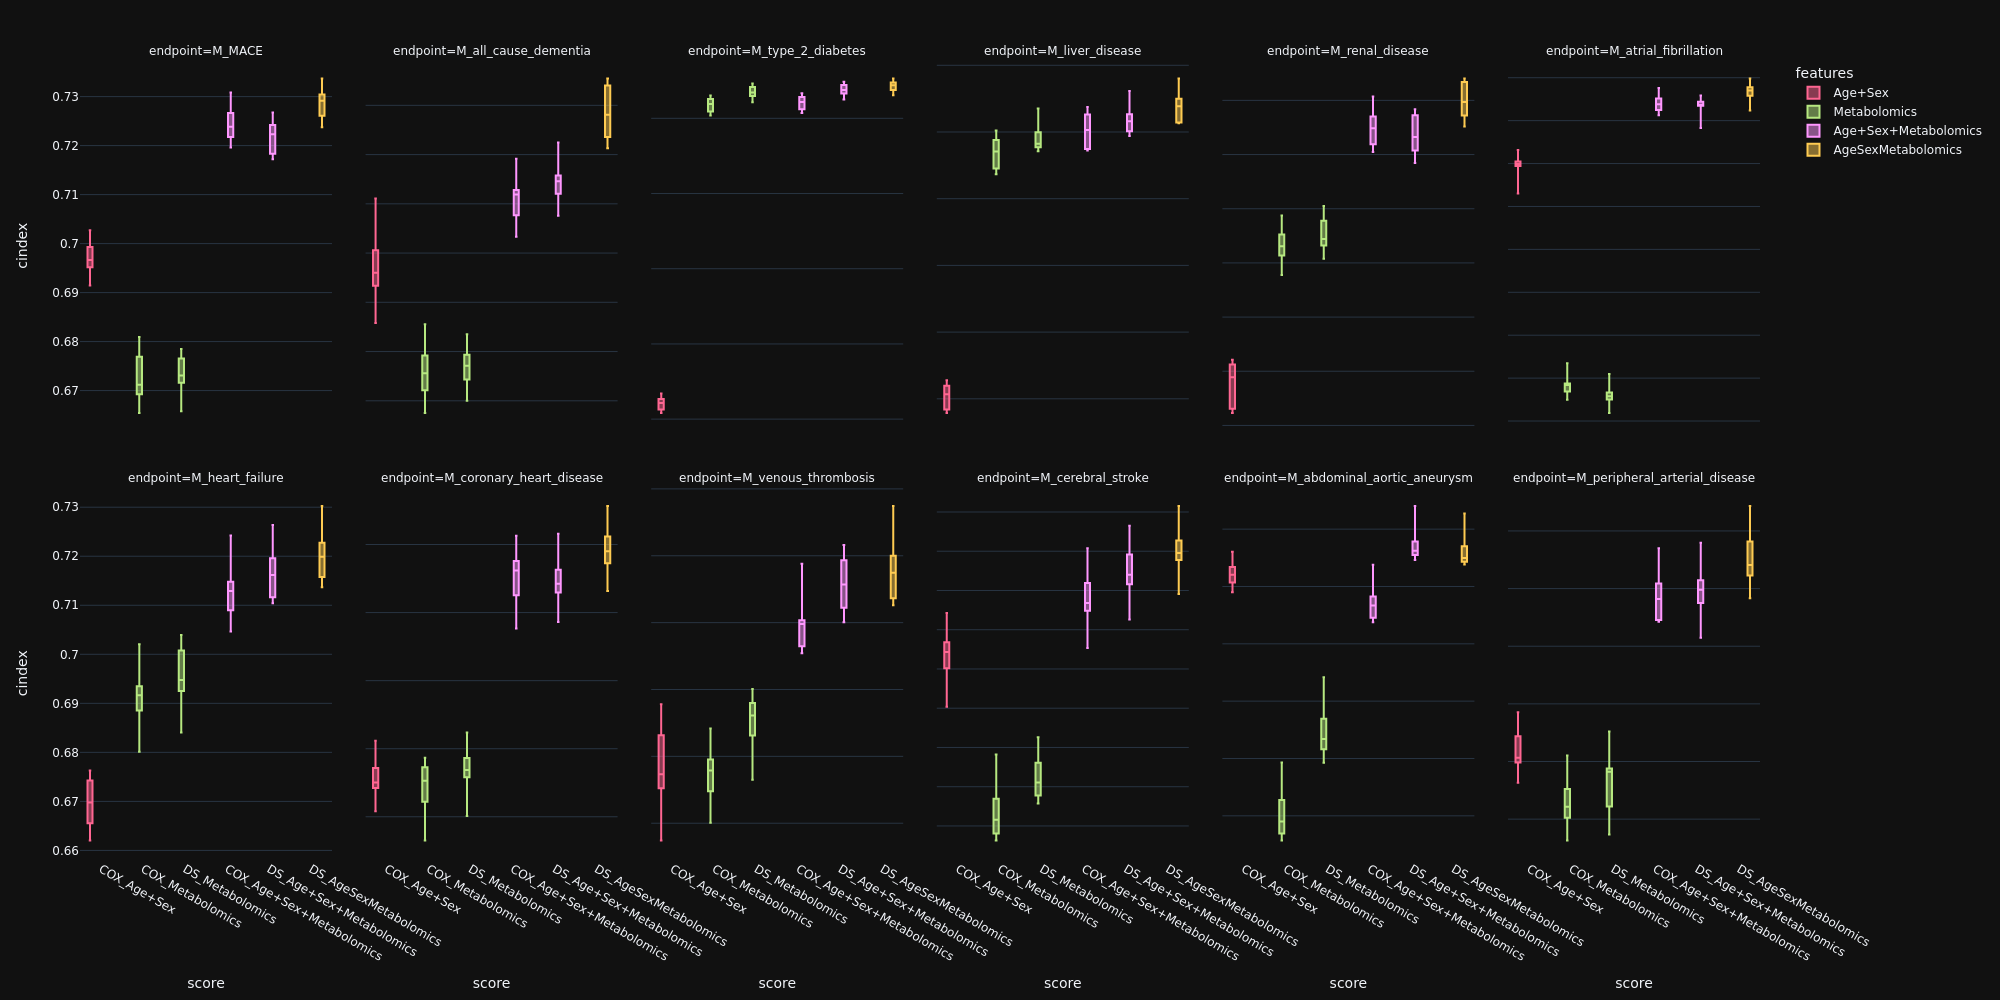

In [73]:
import plotly.express as px
scores_plot = ["COX_Age+Sex", "COX_Metabolomics", "DS_Metabolomics", "COX_Age+Sex+Metabolomics", "DS_Age+Sex+Metabolomics", "DS_AgeSexMetabolomics"]
temp = benchmark_endpoints_pp.assign(score = lambda x: x.module + "_" + x.features).query("score==@scores_plot")
fig = px.box(temp, y="cindex", x="score", points=False, color="features", facet_col="endpoint", facet_col_wrap=6, template="plotly_dark",
               category_orders={"features": ["COX_Age+Sex", "COX_Metabolomics", "DS_Metabolomics", "COX_Age+Sex+Metabolomics", "DS_Age+Sex+Metabolomics", "DS_AgeSexMetabolomics"]})
fig.update_xaxes(matches=None)
fig.update_yaxes(matches=None)
fig.show("png", width=2000, height=1000)

In [ ]:
import plotly.express as px
scores_plot = ["COX_Age+Sex", "COX_Metabolomics", "DS_Metabolomics", "COX_Age+Sex+Metabolomics", "DS_Age+Sex+Metabolomics", "DS_AgeSexMetabolomics"]
temp = benchmark_endpoints_pp.assign(score = lambda x: x.module + "_" + x.features).query("score==@scores_plot")
fig = px.box(temp, y="cindex", x="score", points=False, color="features", facet_col="endpoint", facet_col_wrap=6, template="plotly_dark",
               category_orders={"features": ["COX_Age+Sex", "COX_Metabolomics", "DS_Metabolomics", "COX_Age+Sex+Metabolomics", "DS_Age+Sex+Metabolomics", "DS_AgeSexMetabolomics"]})
fig.update_xaxes(matches=None)
fig.update_yaxes(matches=None)
fig.show("png", width=2000, height=1000)

In [ ]:
import plotly.express as px
temp = benchmark_endpoints_pp
df = px.data.tips()

fig = px.violin(temp, y="cindex", x="features", color="features", box=True, points="all", facet_col="endpoint", facet_col_wrap=4, hover_data=temp.columns, 
                category_orders={"features": ["Age+Sex", "Metabolomics", "Age+Sex+Metabolomics", "AgeSexMetabolomics"]})
fig.update_yaxes(matches=None)
fig.show("png", width=1500, height=1000)

In [79]:
import plotly.express as px
temp = benchmark_endpoints_pp.query("endpoint=='MACE'")
fig = px.violin(temp, y="cindex", x="features", color="features", box=True, points="all", facet_col="module", hover_data=temp.columns)
fig.update_xaxes(matches=None)
fig.show("png")

UnboundLocalError: local variable 'fig' referenced before assignment

In [ ]:
import plotly.express as px
fig = px.box(benchmark_endpoints_pp.groupby("score").mean().sort_index(level=["SCORE", "ASCVD", "QRISK3", "COX_clinical", "DSM_clinical", "COX_clinical_pgs", "DSM_clinical_pgs"]).reset_index(),x="score", y="cindex")
fig.update_xaxes(categoryorder='total ascending')
fig.show("png")

In [74]:
import plotly.express as px
fig = px.box(benchmark_endpoints_pp.groupby("score").mean().sort_index(level=["SCORE", "SCORE2", "ASCVD", "QRISK3", "COX_clinical", "DSM_clinical", "COX_clinical_pgs", "DSM_clinical_pgs"]).reset_index(),x="score", y="cindex")
fig.update_xaxes(categoryorder='total ascending')
fig.show("png")

KeyError: 'score'